In [6]:
import os
os.getcwd()

# Change directory to main repository directory in order to install modules
os.chdir(f"{os.environ['HOME']}/Code/ExoTiC-NEAT-training/")
os.environ["CUDA_VISIBLE_DEVICES"]="-1" # Disable GPU

In [7]:
import numpy as np
import tensorflow as tf

from keras.layers import (
    Activation,
    BatchNormalization,
    Concatenate,
    Conv2D,
    Conv2DTranspose,
    Dropout,
    Input,
    MaxPooling2D,
)

from astropy.io import fits
from keras.models import Model
from keras.optimizers import Adam, schedules
from matplotlib import pyplot as plt
from skimage.filters import threshold_otsu

In [8]:
"""UNet model for image segmentation in keras."""

class Unet:
    """UNet model for image segmentation."""

    def __init__(
        self,
        input_shape: tuple,
        filters: int = 16,
        dropout: float = 0.05,
        batch_normalisation: bool = True,
        trained_model: str = None,
        image: np.ndarray = None,
        layers: int = 4,
        output_activation: str = "sigmoid",
        model: Model = None,
        reconstructed: np.ndarray = None,
    ):
        """
        Initialise the UNet model.

        Parameters
        ----------
        input_shape : tuple
            The shape of the input image.
        filters : int
            The number of filters to use in the convolutional layers, default is 16.
        dropout : float
            The dropout rate, default is 0.05.
        batch_normalisation : bool
            Whether to use batch normalisation, default is True.
        trained_model : str
            The path to a trained model.
        image : np.ndarray
            The image to decode. Image must be 2D given as 4D numpy array, e.g. (1, 256, 256, 1).
            Image must be grayscale, e.g. not (1, 256, 256, 3). Image array row columns must
            be divisible by 2^layers, e.g. 256 % 2^4 == 0.
        layers : int
            The number of encoding and decoding layers, default is 4.
        output_activation : str
            The activation function for the output layer, either sigmoid or softmax.
            Default is sigmoid.
        model : keras.models.Model
            A pre-built model, populated by the build_model method.
        reconstructed : np.ndarray
            The reconstructed image, created by the decode_image method.
        """
        self.input_shape = input_shape
        self.filters = filters
        self.dropout = dropout
        self.batch_normalisation = batch_normalisation
        self.trained_model = trained_model
        self.image = image
        self.layers = layers
        self.output_activation = output_activation
        self.model = model
        self.reconstructed = reconstructed

        self.model = self.build_model()

    def convolutional_block(self, input_tensor, filters, kernel_size=5):
        """Convolutional block for UNet."""
        convolutional_layer = Conv2D(
            filters=filters,
            kernel_size=(kernel_size, kernel_size),
            kernel_initializer="he_normal",
            padding="same",
        )
        batch_normalisation_layer = BatchNormalization()
        relu_layer = Activation("relu")

        if self.batch_normalisation:
            return relu_layer(batch_normalisation_layer(convolutional_layer(input_tensor)))
        return relu_layer(convolutional_layer(input_tensor))

    def encoding_block(self, input_tensor, filters, kernel_size=3):
        """Encoding block for UNet."""
        convolutional_block = self.convolutional_block(input_tensor, filters, kernel_size)
        max_pooling_layer = MaxPooling2D((2, 2), padding="same")
        dropout_layer = Dropout(self.dropout)

        return convolutional_block, dropout_layer(max_pooling_layer(convolutional_block))

    def decoding_block(self, input_tensor, concat_tensor, filters, kernel_size=5):
        """Decoding block for UNet."""
        transpose_convolutional_layer = Conv2DTranspose(
            filters, (kernel_size, kernel_size), strides=(2, 2), padding="same"
        )
        skip_connection = Concatenate()(
            [transpose_convolutional_layer(input_tensor), concat_tensor]
        )
        dropout_layer = Dropout(self.dropout)
        return self.convolutional_block(dropout_layer(skip_connection), filters, kernel_size)

    def build_model(self):
        """Build the UNet model."""
        input_image = Input(self.input_shape, name="img")
        current = input_image

        # Encoding Path
        convolutional_tensors = []
        for layer in range(self.layers):
            convolutional_tensor, current = self.encoding_block(
                current, self.filters * (2 ** layer)
            )
            convolutional_tensors.append((convolutional_tensor))

        # Latent Convolutional Block
        latent_convolutional_tensor = self.convolutional_block(
            current, filters=self.filters * 2 ** self.layers
        )

        # Decoding Path
        current = latent_convolutional_tensor
        for layer in reversed(range(self.layers)):
            current = self.decoding_block(
                current, convolutional_tensors[layer], self.filters * (2 ** layer)
            )

        outputs = Conv2D(1, (1, 1), activation=self.output_activation)(current)
        model = Model(inputs=[input_image], outputs=[outputs])
        return model

    def compile_model(self):
        """Compile the UNet model."""
        self.model.compile(
            optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy", "iou_score"]
        )
        return self.model

    def decode_image(self):
        """Returns images decoded by a trained model."""
        print(f"Predicting source segmentation using pre-trained model...")
        if self.trained_model is None or self.image is None:
            raise ValueError("Trained model and image arguments are required to decode image.")
        if isinstance(self.image, np.ndarray) is False:
            raise TypeError("Image must be a numpy array.")
        if len(self.image.shape) != 4:
            raise ValueError("Image must be 4D numpy array for example (1, 256, 256, 1).")
        if self.image.shape[3] != 1:
            raise ValueError("Input image must be grayscale.")
        if (
            self.image.shape[0] % 2 ** self.layers != 0
            and self.image.shape[1] % 2 ** self.layers != 0
        ):
            raise ValueError("Image shape should be divisible by 2^layers.")

        self.model = self.compile_model()
        self.model.load_weights(self.trained_model)
        self.reconstructed = self.model.predict(self.image)
        return self.reconstructed

In [9]:
train_file = "unet/data/training_data_3000.npy"
validation_file = "unet/data/validation_data_3000.npy"
test_file = "unet/data/test_data_3000.npy"

def normalise_data(data, normalise_max=300):
    """Normalise data using input data for min and max."""

    input_rebined = data[0].reshape(256, 256, 8).sum(axis=2)
    clean_rebined = data[1].reshape(256, 256, 8).sum(axis=2)
    contaminant_rebined = data[2].reshape(256, 256, 8).sum(axis=2)

    data_max = np.max(input_rebined)
    normalisation_factor = normalise_max / data_max

    input_normalised = input_rebined * normalisation_factor
    clean_normalised = clean_rebined * normalisation_factor
    contaminant_normalised = contaminant_rebined * normalisation_factor

    return np.asarray([input_normalised, clean_normalised, contaminant_normalised])

    # input_normalised = data[0] * normalisation_factor
    # clean_normalised = data[1] * normalisation_factor
    # contaminant_normalised = data[2] * normalisation_factor

    # input_normalised_rebinned = input_normalised.reshape(256, 256, 8).sum(axis=2)
    # clean_normalised_rebinned = clean_normalised.reshape(256, 256, 8).sum(axis=2)
    # contaminant_normalised_rebinned = contaminant_normalised.reshape(256, 256, 8).sum(axis=2)
    # return np.asarray([input_normalised_rebinned, clean_normalised_rebinned, contaminant_normalised_rebinned])

def load_data(file):
    data = np.load(file)
    data_transposed = data.transpose (1, 0, 2, 3)
    data_normalised = np.asarray([normalise_data(data) for data in data_transposed])
    normalised_transposed = data_normalised.transpose (1, 0, 2, 3)
    simulations = normalised_transposed[0]
    clean_simulations = normalised_transposed[1]
    contaminant_simulations = normalised_transposed[2]

    simulations_data = np.log1p(np.asarray(simulations, dtype=np.float32))
    clean_simulations_data = np.log1p(np.asarray(clean_simulations, dtype=np.float32))
    contaminant_simulations_data = np.log1p(np.asarray(contaminant_simulations, dtype=np.float32))
    
    return simulations_data, clean_simulations_data, contaminant_simulations_data

# def load_data(file):
#     data = np.load(file)

#     simulations = np.log1p(np.asarray(data[0], dtype=np.float32))
#     clean_simulations = np.log1p(np.asarray(data[1], dtype=np.float32))
#     contaminant_simulations = np.log1p(np.asarray(data[2], dtype=np.float32))

#     return simulations, clean_simulations, contaminant_simulations

train_simulations, train_clean_simulations, train_contaminant_simulations = load_data(train_file)
validation_simulations, validation_clean_simulations, validation_contaminant_simulations = load_data(validation_file)
test_simulations, test_clean_simulations, test_contaminant_simulations = load_data(test_file)


In [10]:
print(f"Train simulations: {train_simulations.shape}")
print(f"Train clean simulations: {train_clean_simulations.shape}")
print(f"Train contaminant simulations: {train_contaminant_simulations.shape}")

print(f"Validation simulations: {validation_simulations.shape}")
print(f"Validation clean simulations: {validation_clean_simulations.shape}")
print(f"Validation contaminant simulations: {validation_contaminant_simulations.shape}")

print(f"Test simulations: {test_simulations.shape}")
print(f"Test clean simulations: {test_clean_simulations.shape}")
print(f"Test contaminant simulations: {test_contaminant_simulations.shape}")

Train simulations: (2400, 256, 256)
Train clean simulations: (2400, 256, 256)
Train contaminant simulations: (2400, 256, 256)
Validation simulations: (300, 256, 256)
Validation clean simulations: (300, 256, 256)
Validation contaminant simulations: (300, 256, 256)
Test simulations: (300, 256, 256)
Test clean simulations: (300, 256, 256)
Test contaminant simulations: (300, 256, 256)


In [11]:
data_train = np.reshape(train_simulations, (train_simulations.shape[0], train_simulations.shape[1], train_simulations.shape[2], 1))
labels_train = np.reshape(train_contaminant_simulations, (train_contaminant_simulations.shape[0], train_contaminant_simulations.shape[1], train_contaminant_simulations.shape[2], 1))

data_validation = np.reshape(validation_simulations, (validation_simulations.shape[0], validation_simulations.shape[1], validation_simulations.shape[2], 1))
labels_validation = np.reshape(validation_contaminant_simulations, (validation_contaminant_simulations.shape[0], validation_contaminant_simulations.shape[1], validation_contaminant_simulations.shape[2], 1))

data_test = np.reshape(test_simulations, (test_simulations.shape[0], test_simulations.shape[1], test_simulations.shape[2], 1))
labels_test = np.reshape(test_contaminant_simulations, (test_contaminant_simulations.shape[0], test_contaminant_simulations.shape[1], test_contaminant_simulations.shape[2], 1))


In [12]:
# calculate average number of zero pixels per image in trianing data
zero_pixels = []
for i in range(labels_train.shape[0]):
    zero_pixels.append(np.sum(labels_train[i] == 0))
print(f"Average number of zero pixels in training label data: {np.mean(zero_pixels)}")
print(f"proportion of zero pixels in training label data: {np.mean(zero_pixels) / (labels_train.shape[1] * labels_train.shape[2])}")

Average number of zero pixels in training label data: 65171.59125
proportion of zero pixels in training label data: 0.9944395637512207


percentage of zero contaminant spectra in train, test and validation
41.66666666666667
0.0
0.0


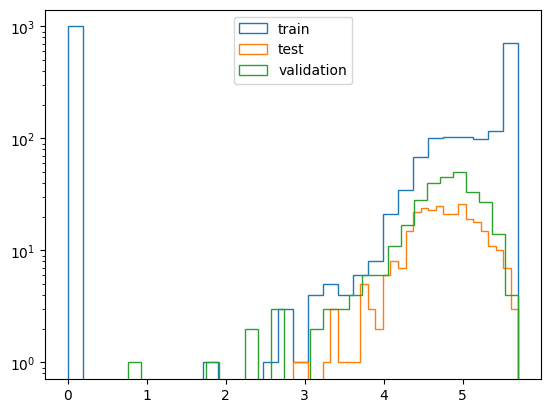

In [13]:
train_max = [slice.max() for slice in labels_train]
test_max = [slice.max() for slice in labels_test]
validation_max = [slice.max() for slice in labels_validation]
plt.hist(train_max, histtype='step', bins=30, label='train')
plt.hist(test_max, histtype='step', bins=30, label='test')
plt.hist(validation_max, histtype='step', bins=30, label='validation')
plt.yscale('log')
plt.legend()

# how many zeros in max arrays
print("percentage of zero contaminant spectra in train, test and validation")
print((np.sum(np.asarray(train_max) == 0) / len(train_max)) * 100)
print((np.sum(np.asarray(test_max) == 0)/ len(test_max) * 100))
print((np.sum(np.asarray(validation_max) == 0)/ len(validation_max) * 100)) 

In [14]:
def calculate_class_percentage(data_array, label_array, clean_array):
    trace_overlap_count = 0
    zero_count = 0
    for data_slice, label_slice, clean_slice in zip(data_array, label_array, clean_array):
        max_data = data_slice.max()
        max_label = label_slice.max()
        max_clean = clean_slice.max()

        if max_label != 0:
            if max_data > max_clean:
                trace_overlap_count += 1
        else:
            zero_count += 1
        
        no_overlap = len(data_array) - trace_overlap_count - zero_count
    return trace_overlap_count / len(data_array), zero_count / len(data_array), no_overlap / len(data_array)

train_trace_overlap, train_zero, train_no_overlap = calculate_class_percentage(data_train, labels_train, train_clean_simulations)
validation_trace_overlap, validation_zero, validation_no_overlap = calculate_class_percentage(data_validation, labels_validation, validation_clean_simulations)
test_trace_overlap, test_zero, test_no_overlap = calculate_class_percentage(data_test, labels_test, test_clean_simulations)

print(f"Train trace overlap: {train_trace_overlap * 100}%")
print(f"Train zero: {train_zero * 100}%")
print(f"Train no overlap: {train_no_overlap * 100}%\n")

print(f"Validation trace overlap: {validation_trace_overlap * 100}%")
print(f"Validation zero: {validation_zero * 100}%")
print(f"Validation no overlap: {validation_no_overlap * 100}%\n")

print(f"Test trace overlap: {test_trace_overlap * 100}%")
print(f"Test zero: {test_zero * 100}%")
print(f"Test no overlap: {test_no_overlap * 100}%\n")



Train trace overlap: 39.08333333333333%
Train zero: 41.66666666666667%
Train no overlap: 19.25%

Validation trace overlap: 4.333333333333334%
Validation zero: 0.0%
Validation no overlap: 95.66666666666667%

Test trace overlap: 6.0%
Test zero: 0.0%
Test no overlap: 94.0%



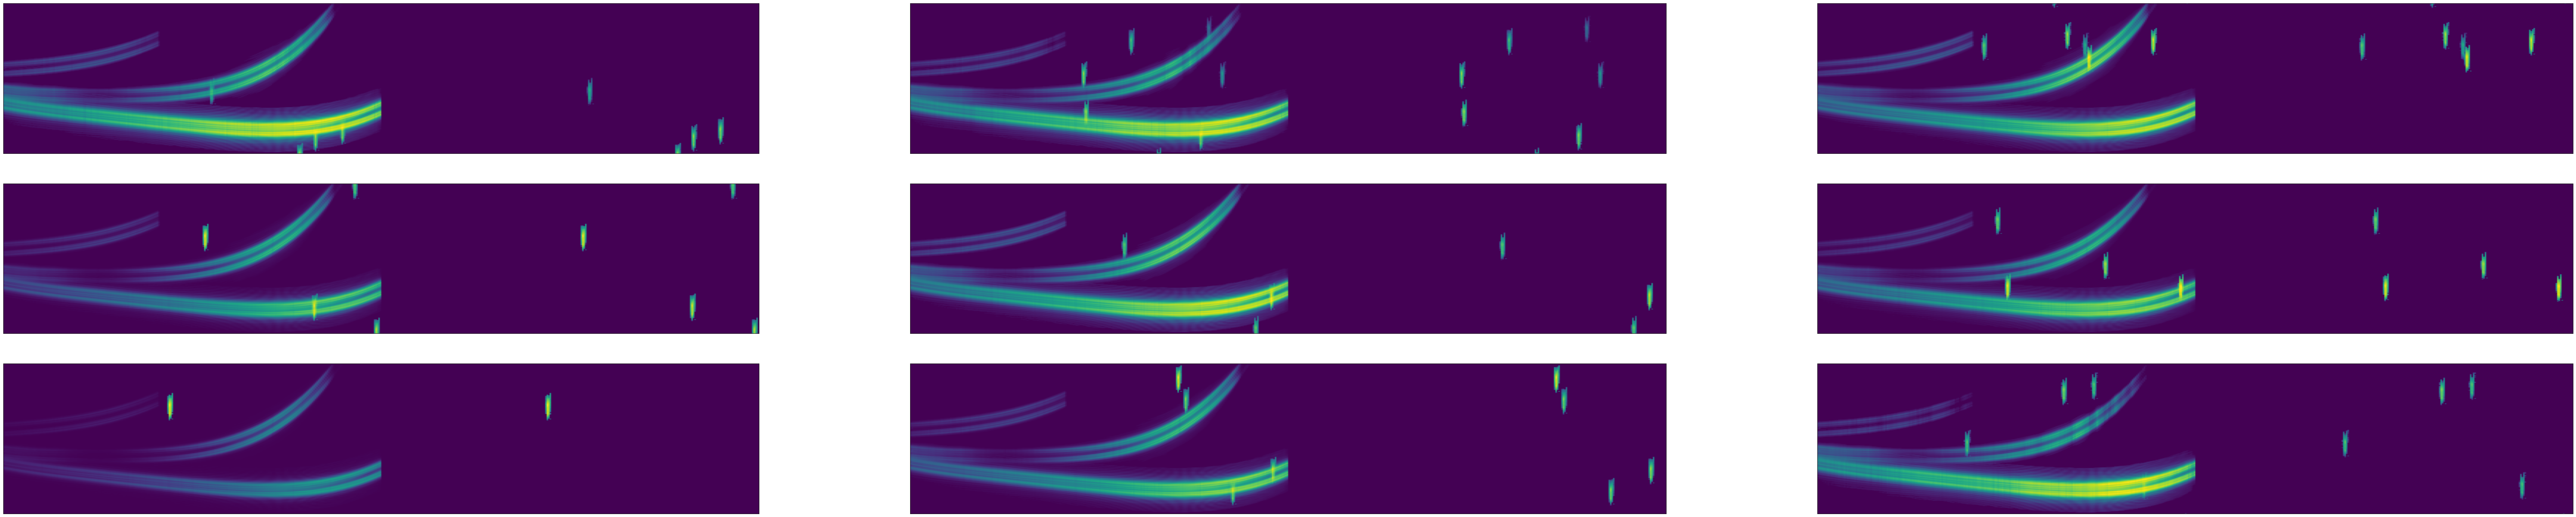

In [19]:
size = 3

fig, axs = plt.subplots(size, size,figsize=(100, 20))

count = 0
for i in range(size):
    for j in range(size):
        
        axs[i, j].imshow(np.concatenate((train_simulations[count], train_contaminant_simulations[count]), axis = -1), origin="lower", cmap="viridis", aspect="auto")
        axs[i, j].get_xaxis().set_visible(False)
        axs[i, j].get_yaxis().set_visible(False)
        count += 1

Text(0.5, 1.0, 'Ground Truth Contaminants')

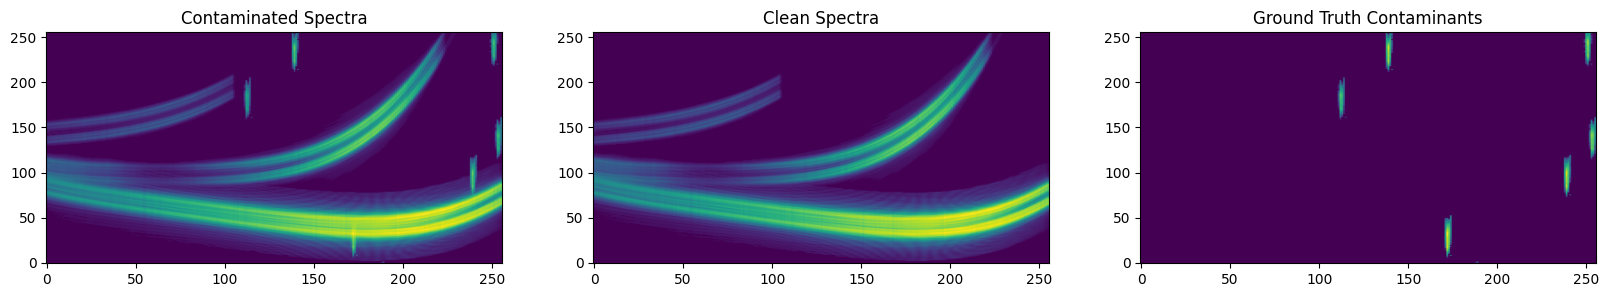

In [20]:
index = 50
fig, ax = plt.subplots(1, 3, figsize=(20, 3))
ax[0].imshow(data_test[index,:,:,0], aspect="auto", origin="lower")
ax[1].imshow(test_clean_simulations[index], aspect="auto", origin="lower")
ax[2].imshow(labels_test[index,:,:,0], aspect="auto", origin="lower")

ax[0].set_title("Contaminated Spectra")
ax[1].set_title("Clean Spectra")
ax[2].set_title("Ground Truth Contaminants")


In [21]:
print(data_test[index].min(), data_test[index].max())
print(labels_test[index].min(), labels_test[index].max())
print(test_clean_simulations[index].min(), test_clean_simulations[index].max())

print((np.exp(data_test[index]) - 1).min(), (np.exp(data_test[index]) - 1).max())
print((np.exp(labels_test[index]) - 1).min(), (np.exp(labels_test[index]) - 1).max())
print((np.exp(test_clean_simulations[index]) - 1).min(), (np.exp(test_clean_simulations[index]) - 1).max())

0.0 5.7071104
0.0 4.6750064
0.0 5.7071104
0.0 300.00003
0.0 106.23325
0.0 300.00003


In [22]:
unet_model = Unet(input_shape=(256, 256, 1), output_activation=None, layers=6)
model = unet_model.model

model.compile(
    optimizer=Adam(),
    loss="mean_squared_error",
    metrics=["accuracy"],
)

unet_model = Unet(input_shape=(256, 2048, 1), output_activation=None, layers=6)
model = unet_model.model
model.compile(optimizer=Adam(learning_rate=0.003), loss="mean_squared_error", metrics=["accuracy"])

In [23]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 img (InputLayer)            [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d_14 (Conv2D)          (None, 256, 256, 16)         160       ['img[0][0]']                 
                                                                                                  
 batch_normalization_13 (Ba  (None, 256, 256, 16)         64        ['conv2d_14[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_13 (Activation)  (None, 256, 256, 16)         0         ['batch_normalization_13

In [24]:
model.load_weights("unet/trained_model_5x5_rebinned.h5")

decoded_images = model.predict(data_test, verbose=1)

10/10 [==============================] - 12s 1s/step


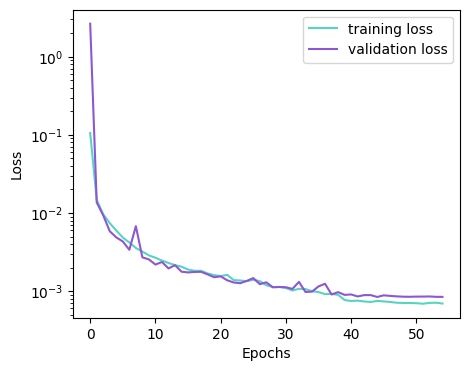

In [25]:
logs = np.load("unet/training_loss_5x5_rebinned.npy", allow_pickle=True)
losses = np.asarray(logs.item()["loss"])
val_losses = np.asarray(logs.item()["val_loss"])

fig, ax = plt.subplots(1, figsize=(5, 4))
ax.plot(losses, label="training loss", color="#57d4c1", marker="None")
ax.plot(val_losses, label="validation loss", color="#8d57d4", marker="None")

ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_yscale("log")
ax.legend()

Text(0.5, 1.0, 'Predicted Clean Spectra')

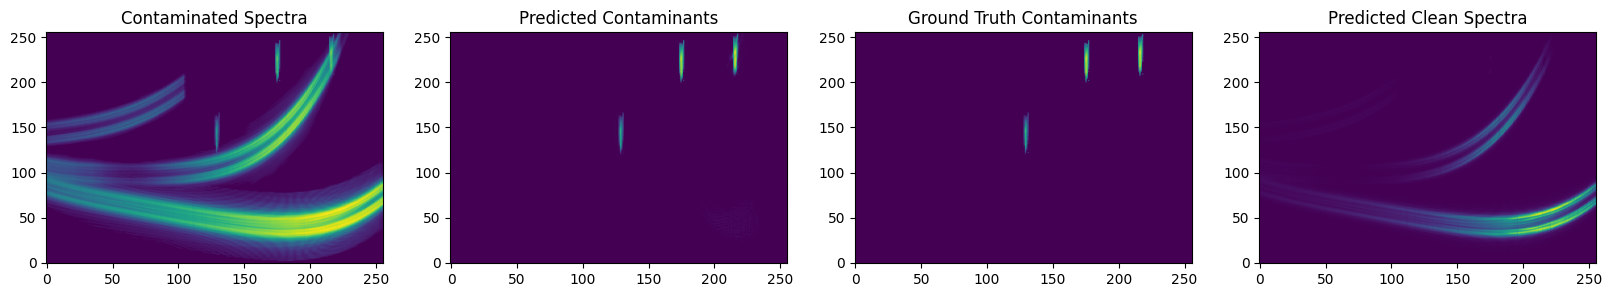

In [44]:
index = 4
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax[0].imshow(data_test[index,:,:,0], aspect="auto", origin="lower", vmin=0)
ax[1].imshow(decoded_images[index,:,:,0], aspect="auto", origin="lower", vmin=0)
ax[2].imshow(labels_test[index,:,:,0], aspect="auto", origin="lower", vmin=0)
ax[3].imshow((np.exp(data_test[index,:,:,0]) -1) - (np.exp(decoded_images[index,:,:,0]) -1 ), aspect="auto", origin="lower", vmin=0)

ax[0].set_title("Contaminated Spectra")
ax[1].set_title("Predicted Contaminants")
ax[2].set_title("Ground Truth Contaminants")
ax[3].set_title("Predicted Clean Spectra")

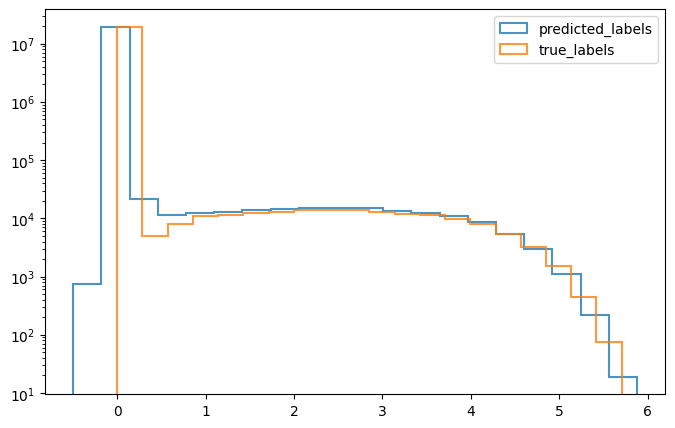

In [27]:
fig, ax = plt.subplots(1, figsize=(8, 5))
ax.hist(decoded_images[:,:,:,0].flatten(), histtype="step", bins=20, label="predicted_labels", linewidth=1.5, alpha=0.8)
ax.hist(labels_test[:,:,:,0].flatten(), histtype="step", bins=20, label="true_labels", linewidth=1.5, alpha=0.8)
ax.legend()

ax.set_yscale("log")

In [28]:
test_clipping = decoded_images[index, :, :, 0]
test_threshold = threshold_otsu(test_clipping)
print(f"threshold: {test_threshold}")
binary_test = test_clipping > test_threshold
test_clipped = np.where(test_clipping < test_threshold, 0, test_clipping)

threshold: 1.2818565368652344


In [29]:
def threshold_images(image):
    """Threshold images using Otsu's method."""
    threshold = threshold_otsu(image)
    binary_image = image > threshold
    clipped_image = np.where(image < threshold, 0, image)
    return clipped_image, binary_image

threhsolded_images = [threshold_images(image) for image in decoded_images]

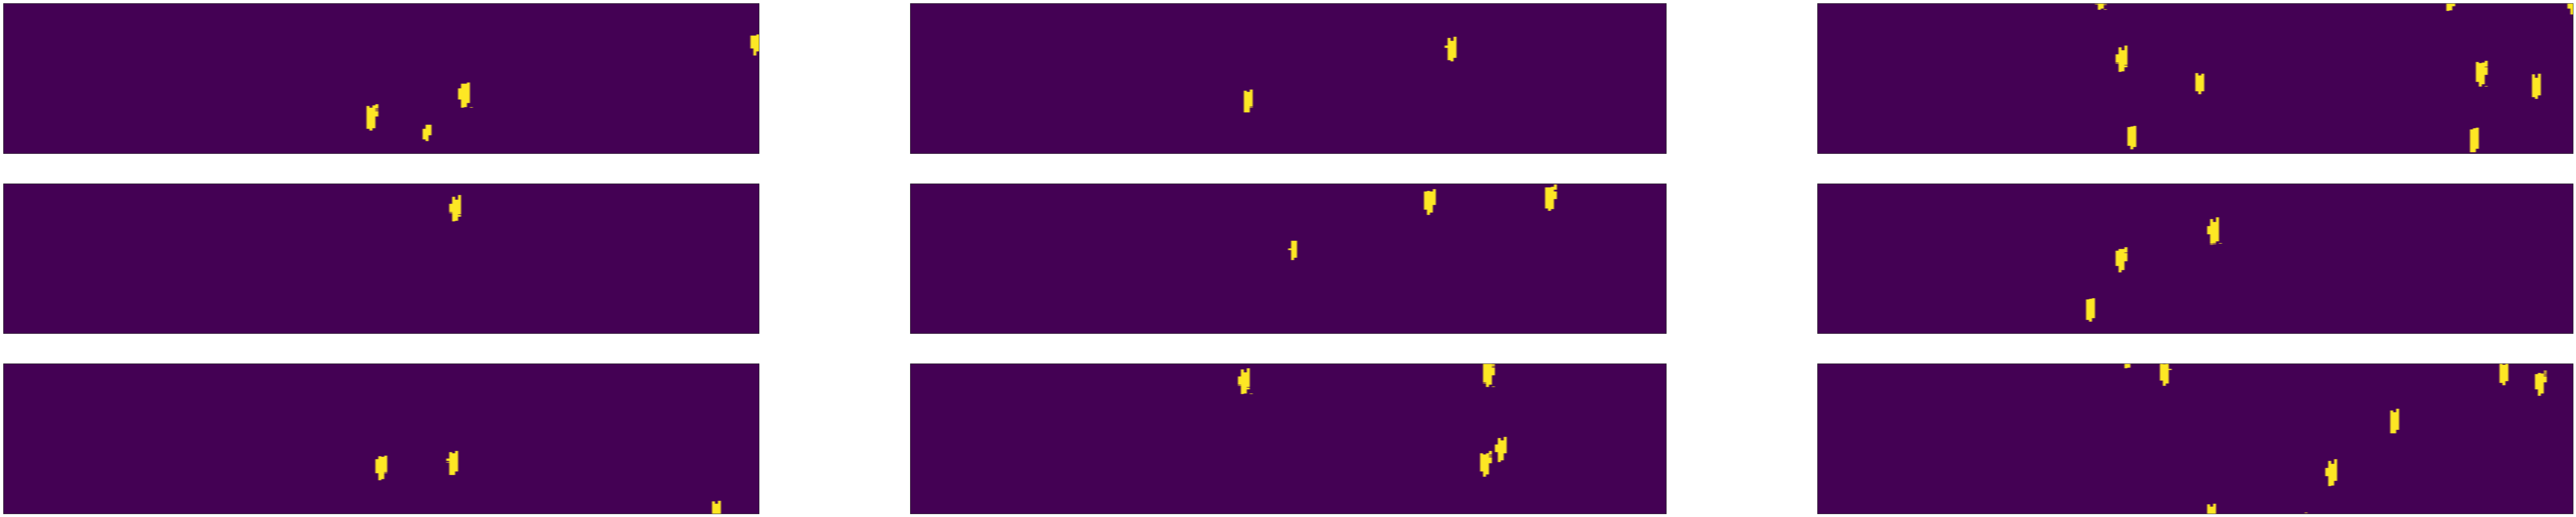

In [30]:
size = 3

fig, axs = plt.subplots(size, size,figsize=(100, 20))

count = 0
for i in range(size):
    for j in range(size):
        
        axs[i, j].imshow(threhsolded_images[count][1][:, :, 0], origin="lower", cmap="viridis", aspect="auto")
        axs[i, j].get_xaxis().set_visible(False)
        axs[i, j].get_yaxis().set_visible(False)
        count += 1

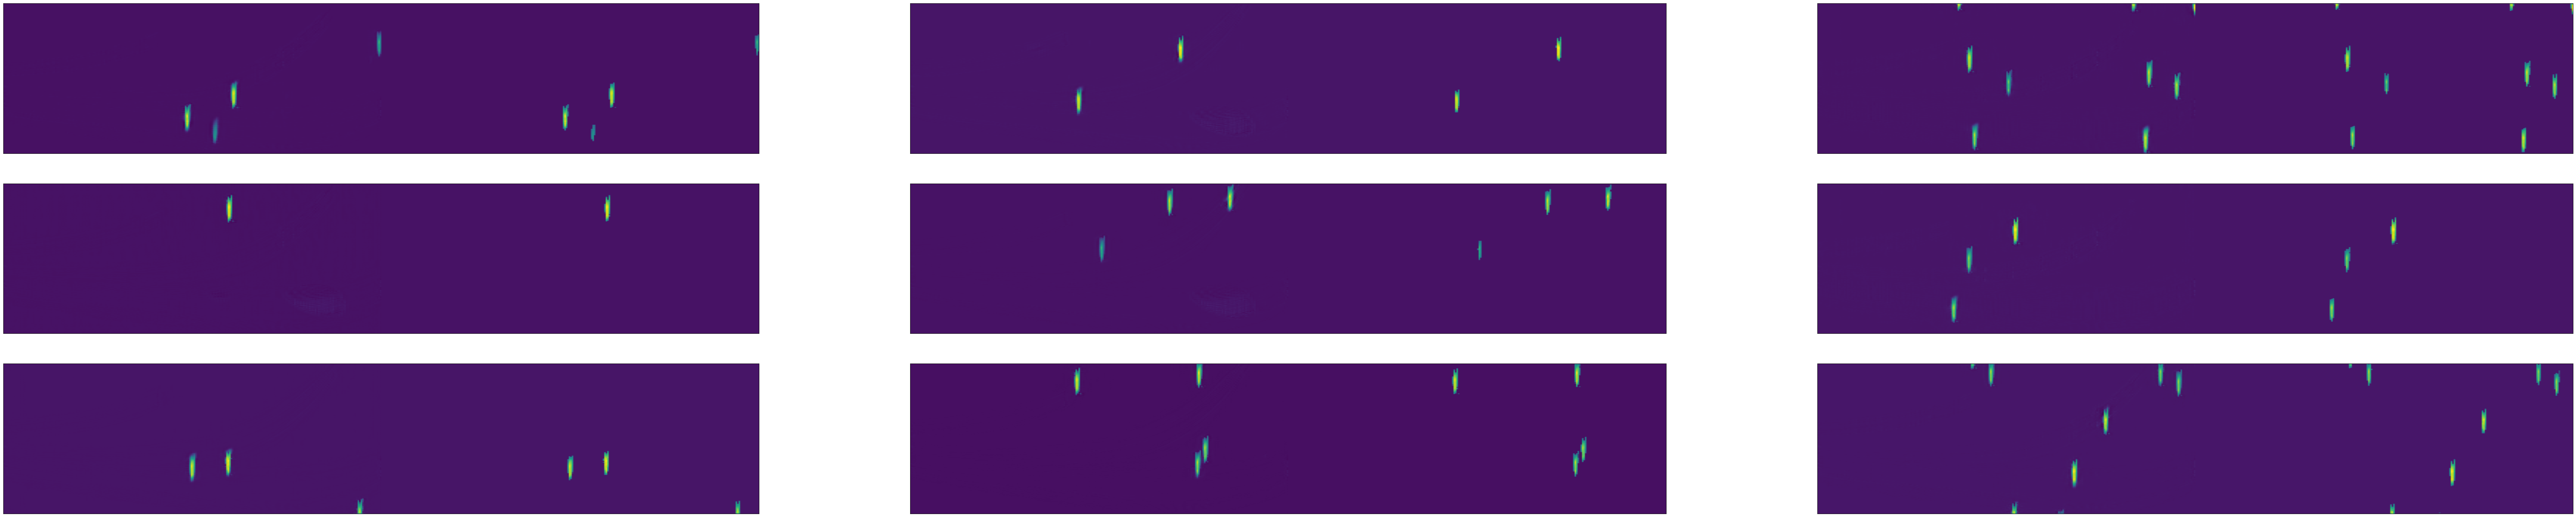

In [31]:
size = 3

fig, axs = plt.subplots(size, size,figsize=(100, 20))

count = 0
for i in range(size):
    for j in range(size):
        
        axs[i, j].imshow(np.concatenate((decoded_images[count, :, :, 0], threhsolded_images[count][0][:, :, 0]), axis = -1), origin="lower", cmap="viridis", aspect="auto")
        axs[i, j].get_xaxis().set_visible(False)
        axs[i, j].get_yaxis().set_visible(False)
        count += 1

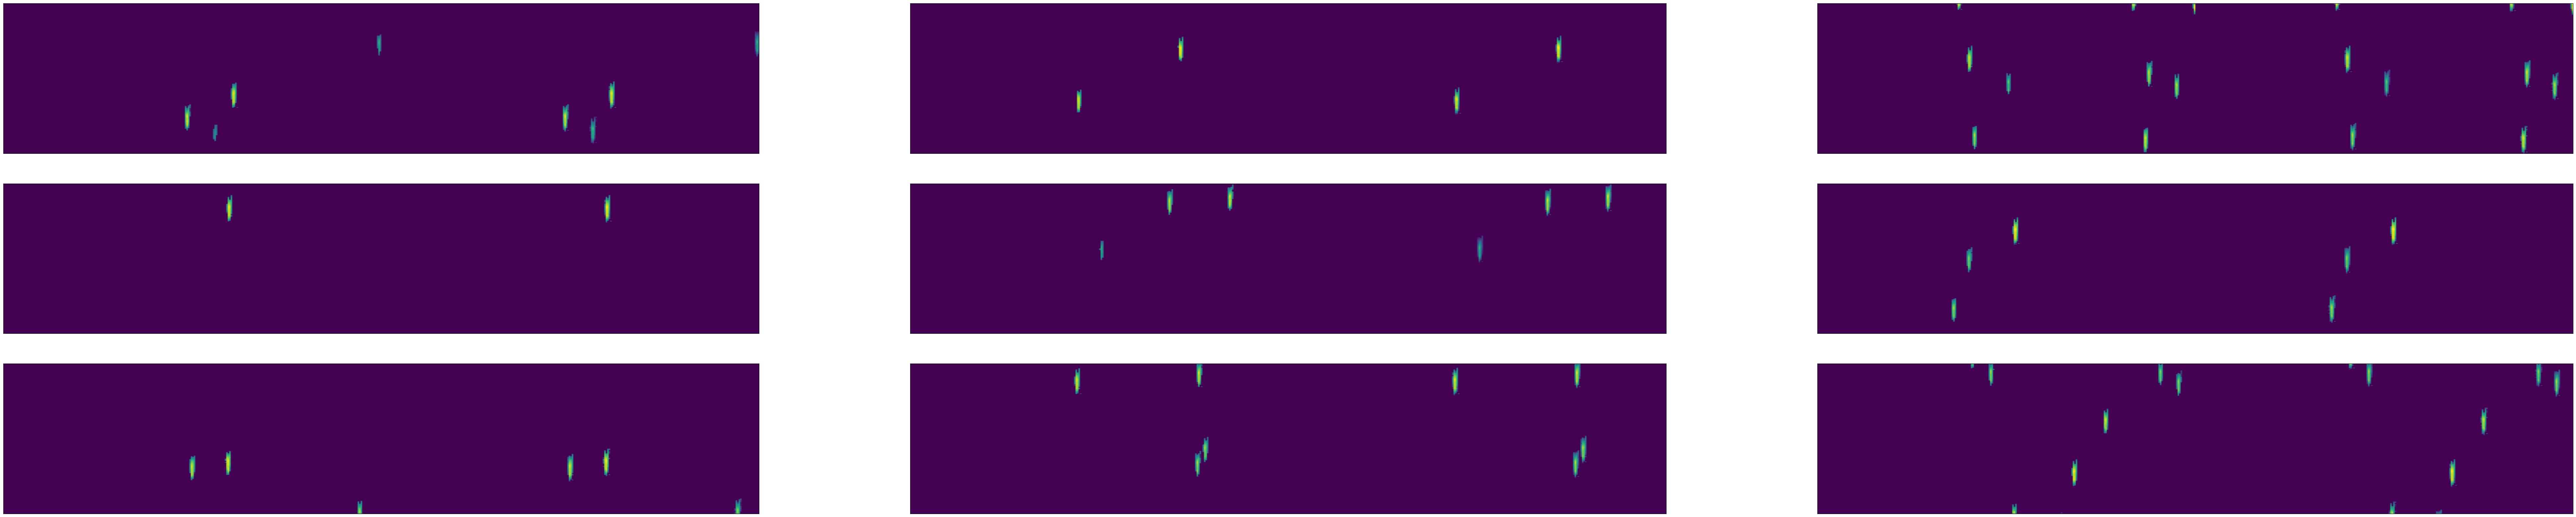

In [32]:
size = 3

fig, axs = plt.subplots(size, size,figsize=(100, 20))

count = 0
for i in range(size):
    for j in range(size):
        
        axs[i, j].imshow(np.concatenate((threhsolded_images[count][0][:, :, 0], labels_test[count, :, :, 0]), axis = -1), origin="lower", cmap="viridis", aspect="auto")
        axs[i, j].get_xaxis().set_visible(False)
        axs[i, j].get_yaxis().set_visible(False)
        count += 1

In [33]:
def get_clean_spectra(input_data, predicted_labels):
    """Get clean spectra by subtracting predicted labels from input data."""
    unlog_input_data = np.expm1(input_data)
    unlog_predicted_labels = np.expm1(predicted_labels)
    return unlog_input_data - unlog_predicted_labels

predicted_clean_spectra = get_clean_spectra(data_test, decoded_images)

Text(0.5, 1.0, 'True Clean Spectra')

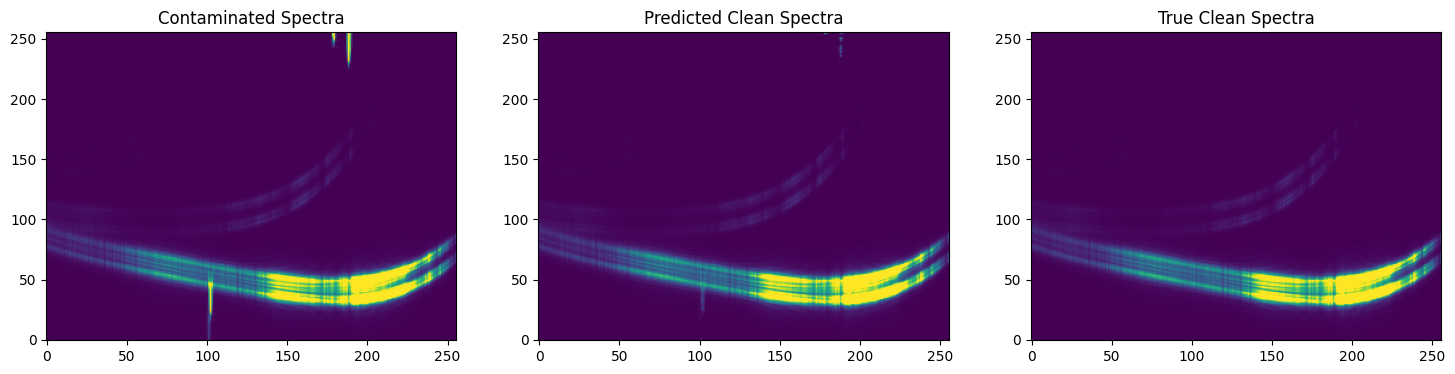

In [34]:
plot_index = 20
fig, ax = plt.subplots(1, 3, figsize=(18, 4))
ax[0].imshow(np.exp(data_test[plot_index, :, :, 0]) - 1, aspect="auto", origin="lower", vmin=0, vmax=100)
ax[1].imshow(predicted_clean_spectra[plot_index, :, :, 0], aspect="auto", origin="lower", vmin=0, vmax=100)
ax[2].imshow((np.exp(test_clean_simulations[plot_index])-1), aspect="auto", origin="lower", vmin=0, vmax=100)

ax[0].set_title("Contaminated Spectra")
ax[1].set_title("Predicted Clean Spectra")
ax[2].set_title("True Clean Spectra")

In [35]:
def calculate_residuals(true_data, predicted_data):
    """Calculate residuals between true and predicted data."""
    return true_data - predicted_data

test_clean_simulations_unlogged = np.expm1(test_clean_simulations)
residuals = calculate_residuals(test_clean_simulations_unlogged, predicted_clean_spectra[:, :, :, 0])

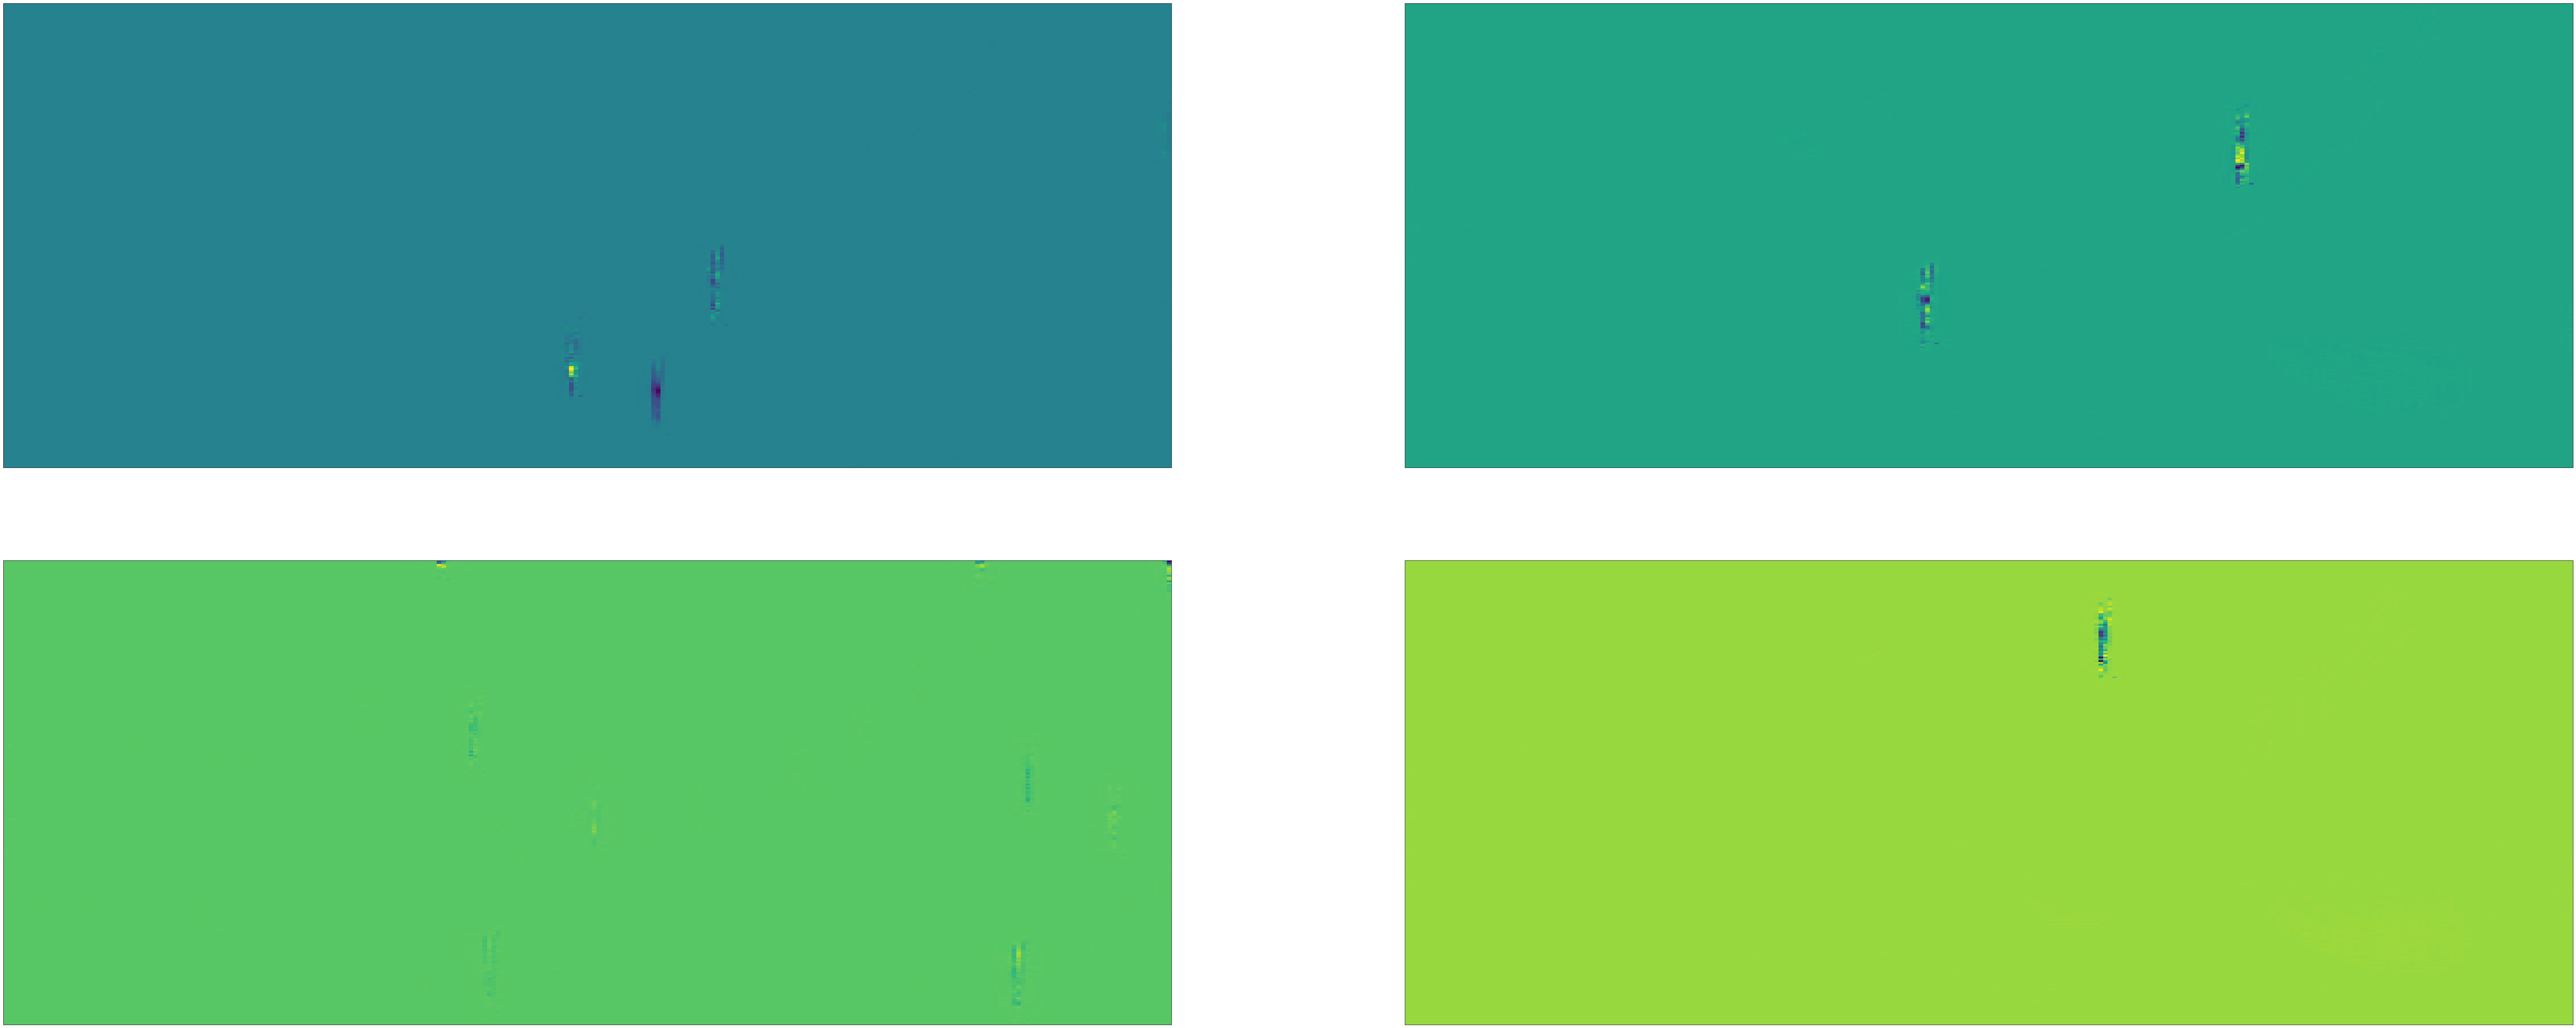

In [36]:
size = 2

fig, axs = plt.subplots(size, size,figsize=(100, 40))

count = 0
for i in range(size):
    for j in range(size):
        
        axs[i, j].imshow(residuals[count], origin="lower", cmap="viridis", aspect="auto")
        axs[i, j].get_xaxis().set_visible(False)
        axs[i, j].get_yaxis().set_visible(False)
        count += 1

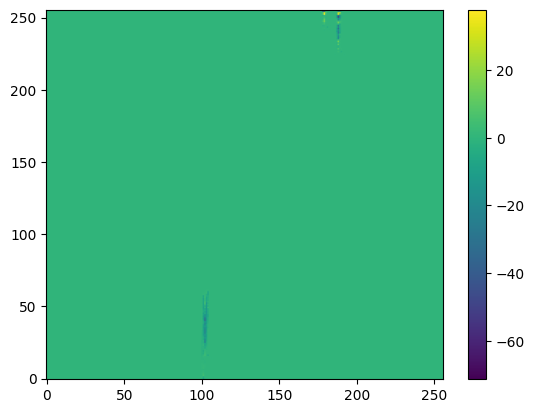

In [37]:
plt.imshow(residuals[plot_index], aspect="auto", origin="lower")
plt.colorbar()

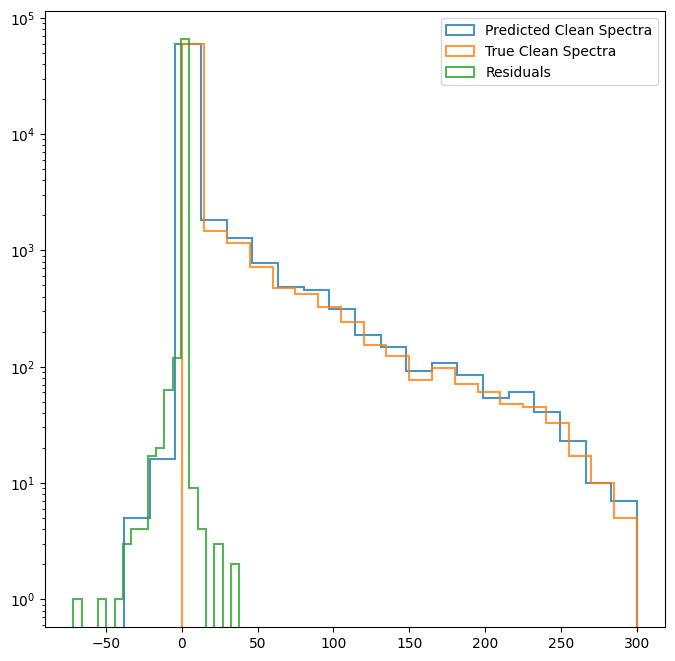

In [38]:
fig, ax = plt.subplots(1, figsize=(8, 8))

ax.hist(predicted_clean_spectra[plot_index].flatten(), bins=20, histtype="step", label="Predicted Clean Spectra", linewidth=1.5, alpha=0.8)
ax.hist(test_clean_simulations_unlogged[plot_index].flatten(), bins=20, histtype="step", label="True Clean Spectra", linewidth=1.5, alpha=0.8)
ax.hist(residuals[plot_index].flatten(), bins=20, histtype="step", label="Residuals", linewidth=1.5, alpha=0.8)

ax.legend()
ax.set_yscale("log")

In [39]:
predicted_labels = np.asarray([image[0] for image in threhsolded_images])
predicted_labels.shape

(300, 256, 256, 1)

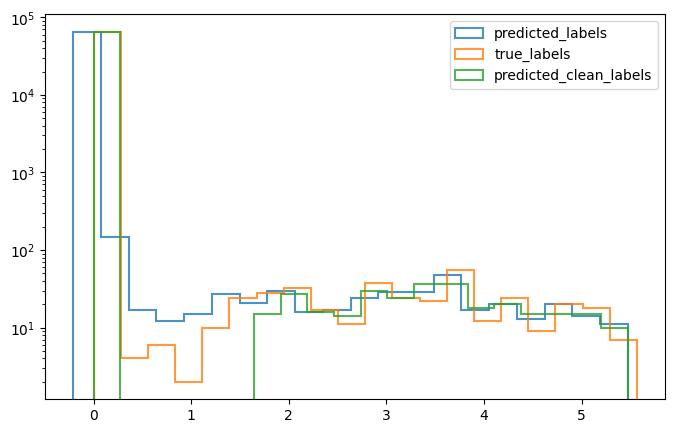

In [40]:
fig, ax = plt.subplots(1, figsize=(8, 5))
ax.hist(decoded_images[plot_index,:,:,0].flatten(), histtype="step", bins=20, label="predicted_labels", linewidth=1.5, alpha=0.8)
ax.hist(labels_test[plot_index,:,:,0].flatten(), histtype="step", bins=20, label="true_labels", linewidth=1.5, alpha=0.8)
ax.hist(predicted_labels[plot_index].flatten(), histtype="step", bins=20, label="predicted_clean_labels", linewidth=1.5, alpha=0.8)
ax.legend()

ax.set_yscale("log")


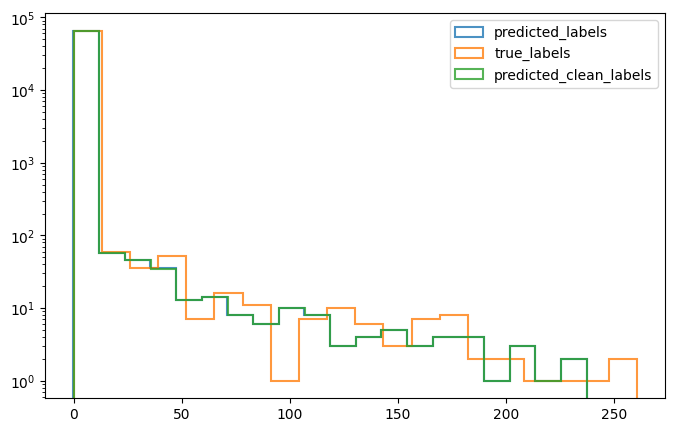

In [41]:
fig, ax = plt.subplots(1, figsize=(8, 5))
ax.hist(np.expm1(decoded_images[plot_index,:,:,0]).flatten(), histtype="step", bins=20, label="predicted_labels", linewidth=1.5, alpha=0.8)
ax.hist(np.expm1(labels_test[plot_index,:,:,0]).flatten(), histtype="step", bins=20, label="true_labels", linewidth=1.5, alpha=0.8)
ax.hist(np.expm1(predicted_labels[plot_index]).flatten(), histtype="step", bins=20, label="predicted_clean_labels", linewidth=1.5, alpha=0.8)
ax.legend()

ax.set_yscale("log")

(1.0030667, 0.019785462)

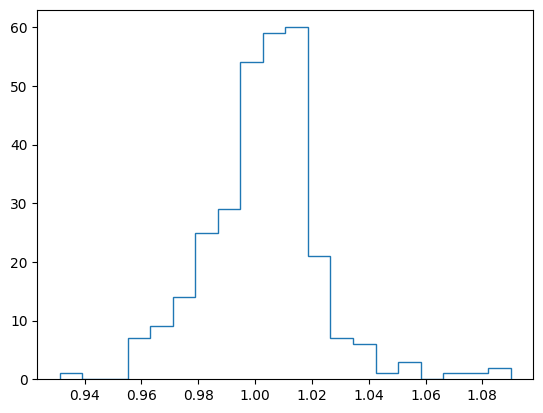

In [42]:
decoded_images_clipped = decoded_images.clip(min=0)
scaling = np.asarray([labels.max() / decoded.max() for labels, decoded in zip(labels_test, decoded_images_clipped)])
plt.hist(scaling, bins=20, histtype="step")
scaling_mean = np.mean(scaling)
scaling_std = np.std(scaling)
scaling_mean, scaling_std

### WASP-39 Test

In [222]:
outdir_s2 = "/data/typhon2/hattie/jwst/wasp_96/pipeline_outputs_directory/Stage2/"
data_filenames = [
    outdir_s2 + "jw02734002001_04101_00001-seg001_nis_badpixstep.fits",
    # outdir_s2 + "jw02734002001_04101_00001-seg002_nis_badpixstep.fits",
    # outdir_s2 + "jw02734002001_04101_00001-seg003_nis_badpixstep.fits",
]

In [223]:
wasp39_data = []
for filename in data_filenames:
    with fits.open(filename) as hdulist:
        wasp39_data.append(hdulist[1].data)

wasp39_data = np.concatenate(wasp39_data, axis=0)
wasp39_data = np.log1p(wasp39_data)
wasp39_data.min(), wasp39_data.max()

(0.0, 5.574177)

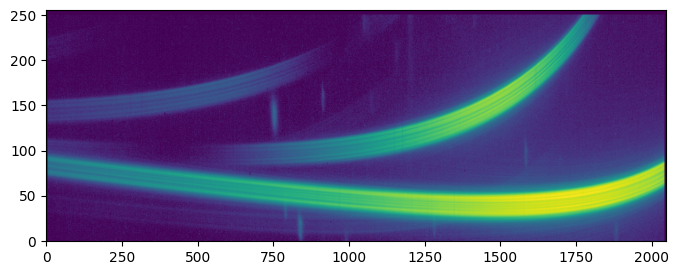

In [224]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.imshow(wasp39_data[0], aspect='auto', origin='lower')

In [225]:
wasp39_data = np.reshape(wasp39_data, (wasp39_data.shape[0], wasp39_data.shape[1], wasp39_data.shape[2], 1))
decoded_wasp39 = model.predict(wasp39_data, verbose=1)

4/4 [==============================] - 19s 4s/step


In [226]:
decoded_wasp39.min(), decoded_wasp39.max()

(-0.2980183, 2.0059135)

In [227]:
thresholded_wasp39 = np.asarray([threshold_images(image) for image in decoded_wasp39])
predicted_labels_wasp39 = np.asarray([image[0] for image in thresholded_wasp39])

In [228]:
predicted_clean_spectra_wasp39 = get_clean_spectra(wasp39_data, decoded_wasp39)

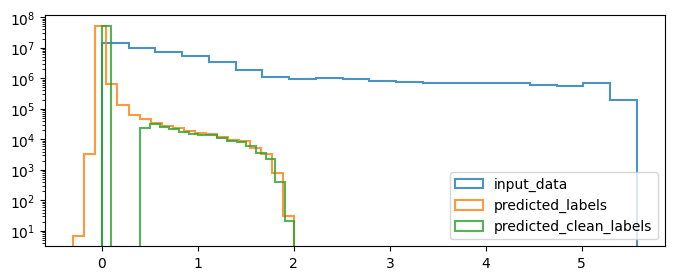

In [229]:
fig, ax = plt.subplots(1, figsize=(8, 3))
ax.hist(wasp39_data.flatten(), bins=20, histtype="step", label="input_data", linewidth=1.5, alpha=0.8)
ax.hist(decoded_wasp39.flatten(), bins=20, histtype="step", label="predicted_labels", linewidth=1.5, alpha=0.8)
ax.hist(predicted_labels_wasp39.flatten(), bins=20, histtype="step", label="predicted_clean_labels", linewidth=1.5, alpha=0.8)
ax.legend()
ax.set_yscale("log")

Text(0.5, 1.0, 'WASP-39 Residuals')

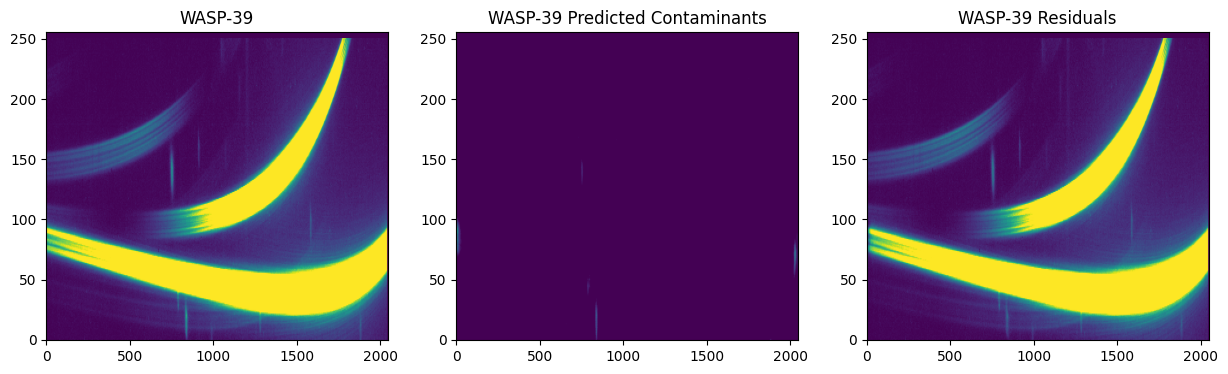

In [238]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax[0].imshow(np.expm1(wasp39_data[0]), aspect="auto", origin="lower", vmin=0, vmax=10)
ax[1].imshow(np.expm1(predicted_labels_wasp39[0]), aspect="auto", origin="lower", vmin=0, vmax=10)
ax[2].imshow(predicted_clean_spectra_wasp39[0], aspect="auto", origin="lower", vmin=0, vmax=10)

ax[0].set_title("WASP-39")
ax[1].set_title("WASP-39 Predicted Contaminants")
ax[2].set_title("WASP-39 Residuals")